# Time-series prediction

Ejemplo de predicción de series temporales.

**Serie de tiempo:** serie de datos puntuales en un orden de tiempo dado (datos discretos).

La predicción de series temporales es el proceso de predecir valores futuros en función del pasado. Por ej. predecir el precio de una acción en función de precios pasados.

<img src="images/timeseries.png" alt="drawing" width="500"/>

In [1]:
import pandas as pd
import math
import matplotlib.pyplot as plt

In [2]:
# Fuente: https://finance.yahoo.com/
df = pd.read_csv('datasets/merval.csv')

In [3]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1997-01-03,639.599976,652.549988,639.599976,651.830017,651.830017,0.0
1,1997-01-06,651.830017,662.030029,651.830017,656.979980,656.979980,0.0
2,1997-01-07,656.979980,663.489990,656.979980,663.489990,663.489990,0.0
3,1997-01-08,664.020020,671.599976,663.719971,664.580017,664.580017,0.0
4,1997-01-09,664.469971,672.169983,664.469971,672.169983,672.169983,0.0


In [4]:
df = df[~df.Close.isna()].reset_index(drop=True)
#df = df.head(20)

In [5]:
df.shape

(2716, 7)

In [6]:
df.dtypes

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume       float64
dtype: object

In [7]:
df.Date.min()

'1997-01-03'

In [8]:
df.Date.max()

'2007-12-28'

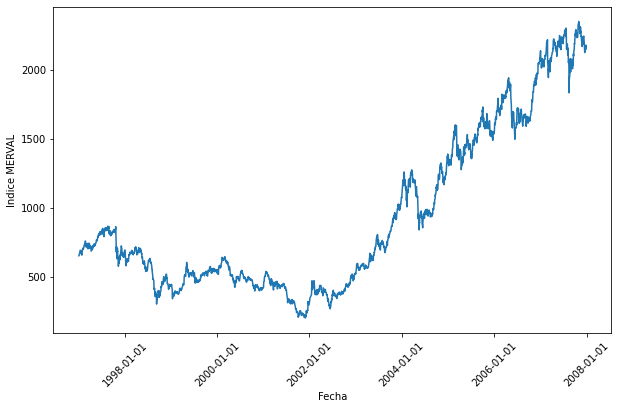

In [9]:
import matplotlib.dates as mdates
import datetime

fmt = mdates.DateFormatter('%Y-%m-%d')
x_date = [datetime.datetime.strptime(i, '%Y-%m-%d') for i in df.Date]

fig, ax = plt.subplots(figsize=(10, 6))


plt.plot(x_date, df.Close)
plt.xticks(rotation=45)
ax.xaxis.set_major_formatter(fmt)

plt.xlabel('Fecha')
plt.ylabel('Indice MERVAL');


### Split dataset

In [10]:
import torch
import torch.nn as nn
import numpy as np

In [11]:
from sklearn.preprocessing import MinMaxScaler

# data leakeage

price = df[['Close']]
scaler = MinMaxScaler(feature_range=(-1, 1))
price.loc[:, 'Close'] = scaler.fit_transform(price['Close'].values.reshape(-1,1))

/var/folders/36/xhls1xbs1676nkndj0s_rtnr0000gn/T/ipykernel_7932/829518123.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price.loc[:, 'Close'] = scaler.fit_transform(price['Close'].values.reshape(-1,1))


In [12]:
df.shape

(2716, 7)

In [13]:
# price = df[['Close']]

In [14]:
def split_data(stock, lookback):
    data_raw = stock.to_numpy()
    data = []
    
    # se crean todas las posibles secuencias de la longitud de la secuencia
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback])
    
    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    
    
   # x_test = data[train_set_size:,:-1]
    #y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train]

lookback = 5 # longitud de secuencia
x_train, y_train = split_data(price, lookback)

In [15]:
def split_data(stock, lookback):
    data_raw = stock.to_numpy()
    data = []
    
    # se crean todas las posibles secuencias de la longitud de la secuencia
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback])
    
    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test, data]

lookback = 5 # longitud de secuencia
x_train, y_train, x_test, y_test, data = split_data(price, lookback)

In [16]:
df.shape

(2716, 7)

In [17]:
data = np.array(price).flatten()

In [18]:
win_dim = 4
win_max = math.floor(data.shape[0] / win_dim) - 1
datas = []
for i in range(1, win_max+1):
    print(i)
    print("Inicio;", win_dim * i)
    print("Fin;", win_dim * (i + 1))
    print(data[win_dim*i : win_dim * (i + 1)])
    datas.append(data[win_dim*i : win_dim * (i + 1)])
    print("-----")
y_datas = np.vstack(datas)

1
Inicio; 4
Fin; 8
[-0.56169034 -0.56284351 -0.55963506 -0.54660601]
-----
2
Inicio; 8
Fin; 12
[-0.5434999  -0.5487915  -0.5534972  -0.54830789]
-----
3
Inicio; 12
Fin; 16
[-0.5482614  -0.55490148 -0.55692884 -0.57119473]
-----
4
Inicio; 16
Fin; 20
[-0.57625383 -0.56714933 -0.5573008  -0.54584341]
-----
5
Inicio; 20
Fin; 24
[-0.54277449 -0.53005234 -0.52882476 -0.53651573]
-----
6
Inicio; 24
Fin; 28
[-0.53757592 -0.5330283  -0.52915029 -0.52835046]
-----
7
Inicio; 28
Fin; 32
[-0.51867869 -0.51305231 -0.51210371 -0.50401286]
-----
8
Inicio; 32
Fin; 36
[-0.50621691 -0.5081699  -0.51092261 -0.49780989]
-----
9
Inicio; 36
Fin; 40
[-0.48078193 -0.48682681 -0.49641492 -0.51331267]
-----
10
Inicio; 40
Fin; 44
[-0.51939473 -0.52050141 -0.51627932 -0.51600033]
-----
11
Inicio; 44
Fin; 48
[-0.51737669 -0.5075747  -0.4967497  -0.5109133 ]
-----
12
Inicio; 48
Fin; 52
[-0.51909719 -0.52764367 -0.52492814 -0.53353047]
-----
13
Inicio; 52
Fin; 56
[-0.52979198 -0.52757862 -0.51392644 -0.50752821]
----

In [19]:
x_train = np.array(x_train[0:678])

In [20]:
x_train.shape

(678, 4, 1)

In [21]:
y_train

array([[-0.56169034],
       [-0.56284351],
       [-0.55963506],
       ...,
       [ 0.3138968 ],
       [ 0.29184686],
       [ 0.30265324]])

In [22]:
y_train

array([[-0.56169034],
       [-0.56284351],
       [-0.55963506],
       ...,
       [ 0.3138968 ],
       [ 0.29184686],
       [ 0.30265324]])

In [23]:
y_train = y_datas

In [23]:
x_train.shape

(678, 4, 1)

In [33]:
x_train

dtype('float64')

In [24]:
y_train.shape

(678, 4)

In [25]:
df.shape

(2716, 7)

In [26]:
x_test.shape

(542, 4, 1)

In [89]:
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
# y_train_lstm = y_train --> los valores REALES contra los que vas a entrenar
y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)
y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor)

### RNN

#### Parametros

* input_size: cantidad de datos en la secuencia de entrada
* hidden_dim: numero de features en el estado oculto
* layer_dim: cantidad de capas recurrentes. Si es 2, con el 2do rnn tomamos la salida del 1er rnn y se calcila el resultado final 
* batch_first: utilizará la primera dimensión como dimensión de secuencia (True)
* dropout: introduce dropout excepto en la ultima capa
* bidirectional: si el contexto tiene importancia (hacia adelante y atrás, en términos temporales)

In [17]:
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob):
        super(RNNModel, self).__init__()

        # definicion del numero de capas y nos por cada una
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        # capas rnn
        self.rnn = nn.RNN(
            input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )
        # capa fc
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, h0):
        # inicializacion del estado oculto con zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        # Propagación hacia adelante pasando la entrada y el estado oculto al modelo
        out, h0 = self.rnn(x, h0.detach()) # detach devuelve un nuevo tensor que no requiere gradiente

        # reshape de output para conectar al fc
        out = out[:, -1, :]

        # convertir el estado final a la forma de salida deseada (batch_size, output_dim)
        out = self.fc(out)
        return out, h0

In [92]:
input_dim = 1
hidden_dim = 64
num_layers = 1
output_dim = 1
num_epochs = 100

model = RNNModel(input_dim, hidden_dim, num_layers, output_dim, 0)
print(model)

criterion = torch.nn.MSELoss()
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

RNNModel(
  (rnn): RNN(1, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)


In [93]:
import time
hist = np.zeros(num_epochs)
hidden = None
start_time = time.time()
lstm = []

h0 = torch.zeros(num_layers, 5, hidden_dim).requires_grad_()

for t in range(num_epochs):
    y_train_pred, h0 = model(x_train, h0)

    loss = criterion(y_train_pred, y_train_lstm)
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
    
training_time = time.time()-start_time
print("Training time: {}".format(training_time))

Epoch  0 MSE:  0.18830637633800507
Epoch  1 MSE:  0.11452949047088623
Epoch  2 MSE:  0.05437605455517769
Epoch  3 MSE:  0.07006003707647324
Epoch  4 MSE:  0.039918094873428345
Epoch  5 MSE:  0.02280917577445507
Epoch  6 MSE:  0.031956449151039124
Epoch  7 MSE:  0.0016955265309661627
Epoch  8 MSE:  0.02202484756708145
Epoch  9 MSE:  0.012639555148780346
Epoch  10 MSE:  0.008797059766948223
Epoch  11 MSE:  0.015962062403559685
Epoch  12 MSE:  0.0013633511262014508
Epoch  13 MSE:  0.004547824617475271
Epoch  14 MSE:  0.010412092320621014
Epoch  15 MSE:  0.007450014818459749
Epoch  16 MSE:  0.003415637416765094
Epoch  17 MSE:  0.005597742274403572
Epoch  18 MSE:  0.00791674293577671
Epoch  19 MSE:  0.003823088249191642
Epoch  20 MSE:  0.0007952271262183785
Epoch  21 MSE:  0.002960619516670704
Epoch  22 MSE:  0.004340789746493101
Epoch  23 MSE:  0.002159844385460019
Epoch  24 MSE:  0.0016023454954847693
Epoch  25 MSE:  0.003717914456501603
Epoch  26 MSE:  0.0026899329386651516
Epoch  27 MSE

In [33]:
y_train_lstm[0:2]

tensor([[-0.5617],
        [-0.5628]])

In [94]:


predict = pd.DataFrame(scaler.inverse_transform(y_train_pred[0:2].detach().numpy()))
original = pd.DataFrame(scaler.inverse_transform(y_train_lstm[0:2].detach().numpy()))

In [95]:
original

,0
0,672.169983
1,670.929993


In [96]:
predict

,0
0,651.877014
1,656.903442


In [98]:
predict = pd.DataFrame(scaler.inverse_transform(y_train_pred.detach().numpy()))
original = pd.DataFrame(scaler.inverse_transform(y_train_lstm.detach().numpy()))

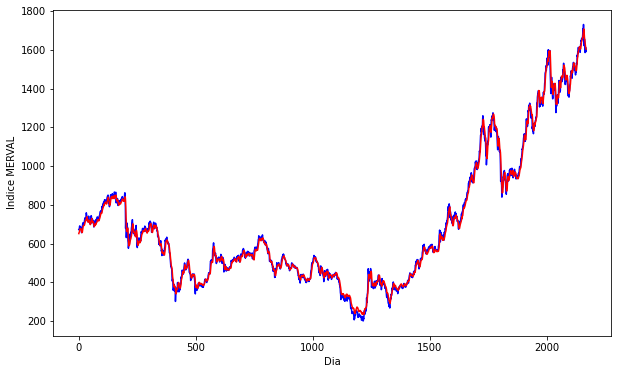

In [99]:
fig, ax = plt.subplots(figsize=(10, 6))

plt.plot(original, c='b')
plt.plot(predict, c='r')
plt.xlabel('Dia')
plt.ylabel('Indice MERVAL');

In [100]:
h0 = torch.zeros(num_layers, 5, hidden_dim).requires_grad_()
y_test_pred, _ = model(x_test, h0)

In [101]:
predict_test = pd.DataFrame(scaler.inverse_transform(y_test_pred.detach().numpy()))


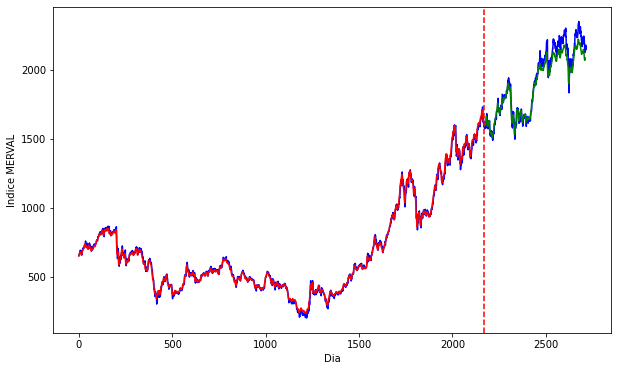

In [102]:
fig, ax = plt.subplots(figsize=(10, 6))

# plt.plot(original.index, original[0], c='b')

plt.plot(df.Close, c='b')
plt.plot(predict.index, predict[0], c='r')
plt.plot(np.arange(predict.index.max() + 1, predict.index.max() + 1 + len(predict_test)), predict_test[0], c='g')
plt.xlabel('Dia')
plt.ylabel('Indice MERVAL');
plt.axvline(x=predict.index.max() + 1, c='r', linestyle='--'); # a donde arranca la prediccion

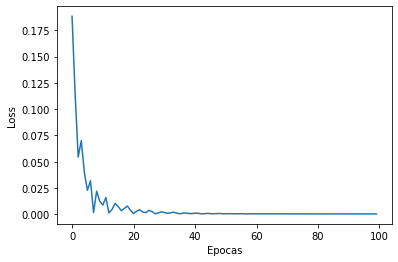

In [103]:
plt.plot(hist);
plt.xlabel('Epocas')
plt.ylabel('Loss');

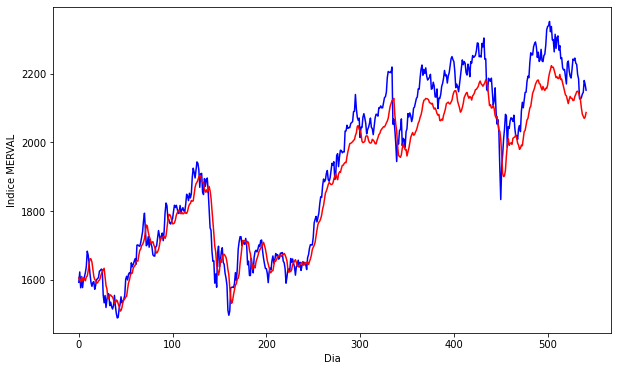

In [104]:
fig, ax = plt.subplots(figsize=(10, 6))

plt.plot(df.loc[len(df)-len(predict_test):len(df), 'Close'].reset_index(drop=True), c='b')
plt.plot(predict_test.index, predict_test[0], c='r')
plt.xlabel('Dia')
plt.ylabel('Indice MERVAL');

### LSTM

In [122]:
input_dim = 1
hidden_dim = 64
num_layers = 5
output_dim = 1
num_epochs = 100

In [123]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [124]:
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.001)

In [125]:
import time
hist = np.zeros(num_epochs)
start_time = time.time()
lstm = []
for t in range(num_epochs):
    y_train_pred = model(x_train)
    loss = criterion(y_train_pred, y_train_lstm)
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
    
training_time = time.time()-start_time
print("Training time: {}".format(training_time))

Epoch  0 MSE:  0.3813767433166504
Epoch  1 MSE:  0.35942015051841736
Epoch  2 MSE:  0.3385533094406128
Epoch  3 MSE:  0.318531334400177
Epoch  4 MSE:  0.29915887117385864
Epoch  5 MSE:  0.2802659273147583
Epoch  6 MSE:  0.26170045137405396
Epoch  7 MSE:  0.24332429468631744
Epoch  8 MSE:  0.2250257283449173
Epoch  9 MSE:  0.20673753321170807
Epoch  10 MSE:  0.1884588748216629
Epoch  11 MSE:  0.17028814554214478
Epoch  12 MSE:  0.1524774134159088
Epoch  13 MSE:  0.13552208244800568
Epoch  14 MSE:  0.12030152976512909
Epoch  15 MSE:  0.10828059166669846
Epoch  16 MSE:  0.10170330852270126
Epoch  17 MSE:  0.10323760658502579
Epoch  18 MSE:  0.1126287505030632
Epoch  19 MSE:  0.12166690081357956
Epoch  20 MSE:  0.12379367649555206
Epoch  21 MSE:  0.1198854148387909
Epoch  22 MSE:  0.11347176134586334
Epoch  23 MSE:  0.10745449364185333
Epoch  24 MSE:  0.10325106978416443
Epoch  25 MSE:  0.10107842087745667
Epoch  26 MSE:  0.10052494704723358
Epoch  27 MSE:  0.10099900513887405
Epoch  28 MS

In [126]:
predict = pd.DataFrame(scaler.inverse_transform(y_train_pred.detach().numpy()))
original = pd.DataFrame(scaler.inverse_transform(y_train_lstm.detach().numpy()))

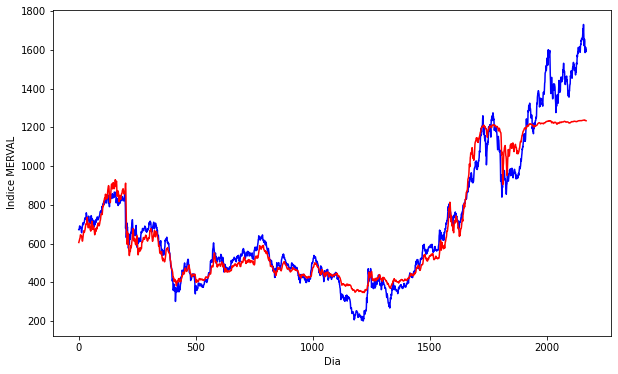

In [127]:
fig, ax = plt.subplots(figsize=(10, 6))

plt.plot(original.index, original[0], c='b')
plt.plot(predict.index, predict[0], c='r')
plt.xlabel('Dia')
plt.ylabel('Indice MERVAL');

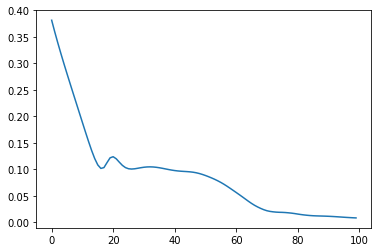

In [128]:
plt.plot(hist)

In [129]:
y_test_pred = model(x_test)

In [130]:
predict_test = pd.DataFrame(scaler.inverse_transform(y_test_pred.detach().numpy()))


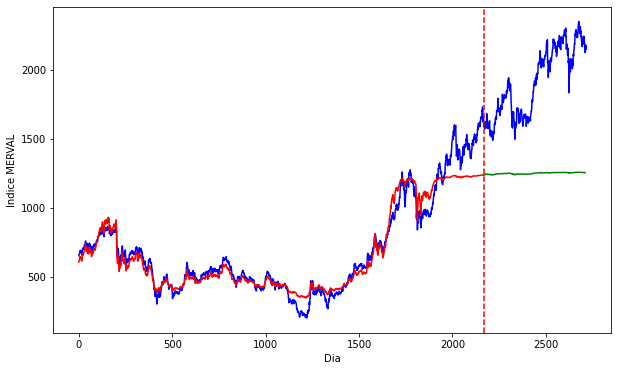

In [131]:
fig, ax = plt.subplots(figsize=(10, 6))

# plt.plot(original.index, original[0], c='b')

plt.plot(df.Close, c='b')
plt.plot(predict.index, predict[0], c='r')
plt.plot(np.arange(predict.index.max() + 1, predict.index.max() + 1 + len(predict_test)), predict_test[0], c='g')
plt.xlabel('Dia')
plt.ylabel('Indice MERVAL');
plt.axvline(x=predict.index.max() + 1, c='r', linestyle='--'); # a donde arranca la prediccion